In [1]:
import sys
sys.path.append('/Users/akash/personal/finance/market-regime/')


import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.neighbors import NearestNeighbors
from models.autoencoder import Autoencoder
from models.contrastive_transformer import ContrastiveTransformer
from utils.config_loader import load_config
from models.storage import save_model, load_model
from torch.utils.tensorboard import SummaryWriter
import os
import modin as mpd
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import ks_2samp, entropy


In [2]:
import sys
import os

# Add the utils directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

import pandas as pd
import modin.pandas as mpd
from utils import clickhouse_data
import numpy as np
import talib
from sklearn.decomposition import PCA

# Define parameters
start_date = '2017-01-01'
end_date = '2025-12-31'

# Load and preprocess data
large_cap = clickhouse_data.clickhouse_largecap(start_date, end_date, size=1)
# mid_cap = clickhouse_data.clickhouse_midcap(start_date, end_date, size=1)
# small_cap = clickhouse_data.clickhouse_smallcap(start_date, end_date)

# # Fill missing dates
# large_cap = clickhouse_data.fill_missing_dates_modin_optimized(large_cap)
# mid_cap = clickhouse_data.fill_missing_dates_modin_optimized(mid_cap)
# small_cap = clickhouse_data.fill_missing_dates_modin_optimized(small_cap)

# Stack dataframes
all_cap = mpd.concat([large_cap])




    SELECT 
        financialinstrumentid,
        date,
        open,
        high,
        low,
        close,
        lastprice,
        previouscloseprice,
        volume,
        totaltradingvolume,
        totaltradevalue,
        totalnumberoftradesexecuted,
        tickersymbol,
        securityseries,
        settlementprice,
        financialinstrumentname
    FROM stock_data.tickers
    WHERE financialinstrumentid IN ('500002',) AND date BETWEEN '2017-01-01' AND '2025-12-31'
    ORDER BY financialinstrumentid, date ASC
    


In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

2025-03-12 02:53:20,689	INFO worker.py:1821 -- Started a local Ray instance.


In [46]:

import numpy as np
import pandas as pd
import talib
from prophet import Prophet

def extract_all_features(df):
    """
    Master function that:
    1. Retains raw OHLCV & additional trading data.
    2. Computes trend-based, volatility, liquidity, and microstructure features.
    3. Computes advanced technical indicators.
    4. Extracts seasonal components using Prophet.
    5. Ensures all feature columns are complete and normalized.
    """
    
    df = df.copy()

    # === Retain Raw Data for Reference ===
    raw_cols = [
        'date', 'open', 'high', 'low', 'close', 'lastprice', 'previouscloseprice',
        'volume', 'totaltradingvolume', 'totaltradevalue', 'totalnumberoftradesexecuted'
    ]
    df = df[raw_cols]  # Ensure we only work with the relevant columns

    # Ensure proper datetime format
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # === Compute Derived Features ===
    
    ## 🔹 Trend-Based Features
    df = clickhouse_data.compute_trend_features(df)

    ## 🔹 Volatility Features
    df = clickhouse_data.compute_volatility_features(df)

    ## 🔹 Liquidity Features (Includes Total Trading Volume & Trade Value)
    df = clickhouse_data.compute_liquidity_features(df)

    ## 🔹 Market Microstructure Features (VWAP, etc.)
    df = clickhouse_data.compute_microstructure_features(df)

    # === Derived Features from Additional Trading Data ===

    # 🔹 Previous Close Return (Gap Indicator)
    df['prev_close_return'] = np.log(df['close'] / df['previouscloseprice'])

    # 🔹 Trading Intensity (Total Trades / Volume)
    df['trading_intensity'] = df['totalnumberoftradesexecuted'] / df['totaltradingvolume']

    # 🔹 Turnover Ratio (Liquidity Proxy)
    df['turnover_ratio'] = df['totaltradevalue'] / df['totaltradingvolume']

    # 🔹 VWAP Ratio (Price Positioning)
    df['vwap_ratio'] = df['close'] / df['vwap']
    
    # 🔹 High-Low & Close-Open Ratios
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']

    # === Advanced Technical Indicators ===
    df['cci_20'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=20)
    df['williams_r'] = talib.WILLR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
    df['stoch_k'], df['stoch_d'] = talib.STOCH(
        df['high'].values, df['low'].values, df['close'].values, 
        fastk_period=14, slowk_period=3, slowd_period=3
    )
    df['chande_momentum'] = talib.CMO(df['close'].values, timeperiod=14)
    df['ulcer_index'] = np.sqrt((df['close'].rolling(14).max().values - df['close'].values) ** 2 / 14)
    df['obv'] = talib.OBV(df['close'].astype(float).values, df['volume'].astype(float).values)
    df['chaikin_money_flow'] = talib.ADOSC(
        df['high'].astype(float).values, df['low'].astype(float).values, df['close'].astype(float).values, df['volume'].astype(float).values, 
        fastperiod=3, slowperiod=10
    )
    
    # === Extract Seasonality Features Using Prophet ===
    df_prophet = df[['close']].reset_index()
    df_prophet.columns = ['ds', 'y']

    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet.fit(df_prophet)

    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)

    df['seasonal_weekly'] = forecast['weekly']
    df['seasonal_yearly'] = forecast['yearly']
    
    # Fill missing values (if any)
    df = df.ffill()
    df.fillna(0, inplace=True)

    return df

featured_df = extract_all_features(all_cap)

# Normalize Features
scaler = StandardScaler()
scaled_df = scaler.fit_transform(featured_df)



03:23:13 - cmdstanpy - INFO - Chain [1] start processing
03:23:14 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Convert Pandas DataFrame to Numpy
scaled_df = np.array(scaled_df)  # Ensure it's a numpy array

# Define sequence length (7-day windows)
seq_len = 7
num_features = scaled_df.shape[1]

# Convert to rolling sequences for LSTM input
X_sequences = []
for i in range(len(scaled_df) - seq_len + 1):
    X_sequences.append(scaled_df[i : i + seq_len])

X_sequences = np.array(X_sequences)  # Shape: (num_samples, seq_len, num_features)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_sequences, dtype=torch.float32)


# LSTM

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(LSTMAutoencoder, self).__init__()

        # LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Bottleneck Layer (Feature Extraction)
        self.fc_bottleneck = nn.Linear(hidden_dim, latent_dim)

        # LSTM Decoder
        self.lstm_decoder = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, input_dim)  # Final output layer

    def forward(self, x):
        # Encode time series
        _, (h_n, _) = self.lstm_encoder(x)
        h_n = h_n.squeeze(0)  # (batch_size, hidden_dim)

        # Bottleneck transformation (feature extraction)
        z = self.fc_bottleneck(h_n)  # (batch_size, latent_dim)

        # Repeat bottleneck feature across timesteps
        z_repeated = z.unsqueeze(1).repeat(1, x.size(1), 1)  # (batch_size, seq_len, latent_dim)

        # Decode sequence
        decoded, _ = self.lstm_decoder(z_repeated)
        decoded = self.fc_output(decoded)

        return decoded, z  # Return reconstructed sequence + extracted features


In [ ]:
import torch.optim as optim

# Hyperparameters
input_dim = num_features
hidden_dim = 64
latent_dim = 10
lr = 0.001
epochs = 50
batch_size = 32

# Initialize Model
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

# Training Loop
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0]  # Extract input
        optimizer.zero_grad()
        
        reconstructed_x, _ = model(x_batch)  # Forward pass
        loss = criterion(reconstructed_x, x_batch)  # Compute loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")


Epoch 1/50, Loss: 0.729076
Epoch 2/50, Loss: 0.468865
Epoch 3/50, Loss: 0.399814
Epoch 4/50, Loss: 0.360741
Epoch 5/50, Loss: 0.327560
Epoch 6/50, Loss: 0.307012
Epoch 7/50, Loss: 0.289035
Epoch 8/50, Loss: 0.275209
Epoch 9/50, Loss: 0.266405
Epoch 10/50, Loss: 0.257206
Epoch 11/50, Loss: 0.249628
Epoch 12/50, Loss: 0.243972
Epoch 13/50, Loss: 0.236499
Epoch 14/50, Loss: 0.232246
Epoch 15/50, Loss: 0.227537
Epoch 16/50, Loss: 0.222495
Epoch 17/50, Loss: 0.220440
Epoch 18/50, Loss: 0.219236
Epoch 19/50, Loss: 0.212655
Epoch 20/50, Loss: 0.212134
Epoch 21/50, Loss: 0.207845
Epoch 22/50, Loss: 0.207046
Epoch 23/50, Loss: 0.205017
Epoch 24/50, Loss: 0.201441
Epoch 25/50, Loss: 0.201205
Epoch 26/50, Loss: 0.199099
Epoch 27/50, Loss: 0.203902
Epoch 28/50, Loss: 0.194073
Epoch 29/50, Loss: 0.190457
Epoch 30/50, Loss: 0.190868
Epoch 31/50, Loss: 0.188423
Epoch 32/50, Loss: 0.212278
Epoch 33/50, Loss: 0.199806
Epoch 34/50, Loss: 0.184957
Epoch 35/50, Loss: 0.180960
Epoch 36/50, Loss: 0.179595
E

In [50]:
# Get Encoded Features (Latent Representations)
with torch.no_grad():
    _, extracted_features = model(X_tensor)

extracted_features = extracted_features.numpy()  # Convert to NumPy for clustering


In [51]:
X = extracted_features
# === Fit GMM ===
n_regimes = 4  # Change this if needed
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
regime_labels = gmm.fit_predict(extracted_features)
featured_df = featured_df.iloc[seq_len - 1:]
featured_df['gmm_regime'] = regime_labels

# === Fit HMM ===
hmm = GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, random_state=42)
hmm.fit(X)
featured_df['hmm_regime'] = hmm.predict(X)

# === Calculate Returns ===
featured_df['log_return'] = np.log(featured_df['close'] / featured_df['close'].shift(1))

# === High-Order Statistics & Summary ===
import numpy as np

def regime_summary(df, regime_col):
    summary = df.groupby(regime_col)['log_return'].agg(
        mean='mean',
        std='std',
        skew='skew',
        kurtosis=pd.Series.kurt  # ✅ FIXED: Use `pd.Series.kurt`
    )

    # Handle division by zero safely
    summary['sharpe'] = np.where(summary['std'] > 0, summary['mean'] / summary['std'], np.nan)

    # Fill NaNs (if any)
    summary.fillna(0, inplace=True)

    return summary

# === Regime Summary ===# === Statistical Evaluation ===
def evaluate_clustering(df, regime_col):
    regimes = df[regime_col].unique()
    
    # Silhouette Score
    silhouette = silhouette_score(X, df[regime_col])
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(X, df[regime_col])
    
    # Kolmogorov-Smirnov Test (compare distributions across regimes)
    ks_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                ks_stat, ks_pval = ks_2samp(
                    df[df[regime_col] == i]['log_return'].dropna(),
                    df[df[regime_col] == j]['log_return'].dropna()
                )
                ks_results[f'{i}-{j}'] = {'ks_stat': ks_stat, 'p_value': ks_pval}
    
    # Kullback-Leibler Divergence (compare probability distributions)
    kl_results = {}
    for i in regimes:
        for j in regimes:
            if i < j:
                p = np.histogram(df[df[regime_col] == i]['log_return'].dropna(), bins=50, density=True)[0]
                q = np.histogram(df[df[regime_col] == j]['log_return'].dropna(), bins=50, density=True)[0]
                p += 1e-10  # Avoid division by zero
                q += 1e-10
                kl_div = entropy(p, q)
                kl_results[f'{i}-{j}'] = kl_div
    
    return {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Kolmogorov-Smirnov': ks_results,
        'KL Divergence': kl_results
    }

# Evaluate GMM and HMM
gmm_eval = evaluate_clustering(featured_df, 'gmm_regime')
hmm_eval = evaluate_clustering(featured_df, 'hmm_regime')




Model is not converging.  Current: 24442.955126613735 is not greater than 24443.027172153674. Delta is -0.07204553993869922


<Figure size 1200x600 with 0 Axes>

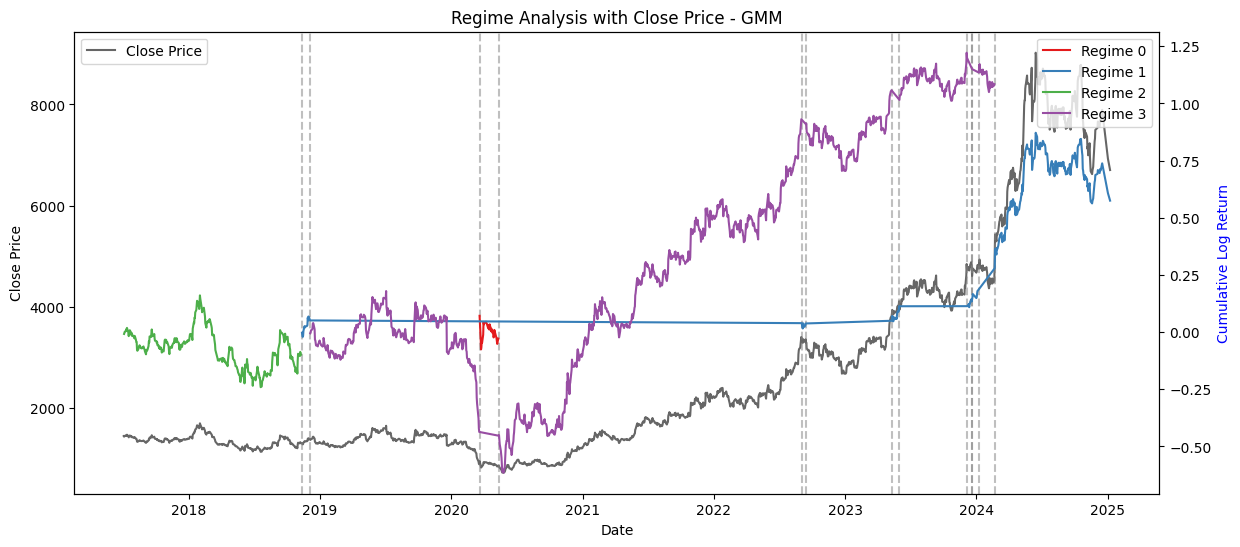

<Figure size 1200x600 with 0 Axes>

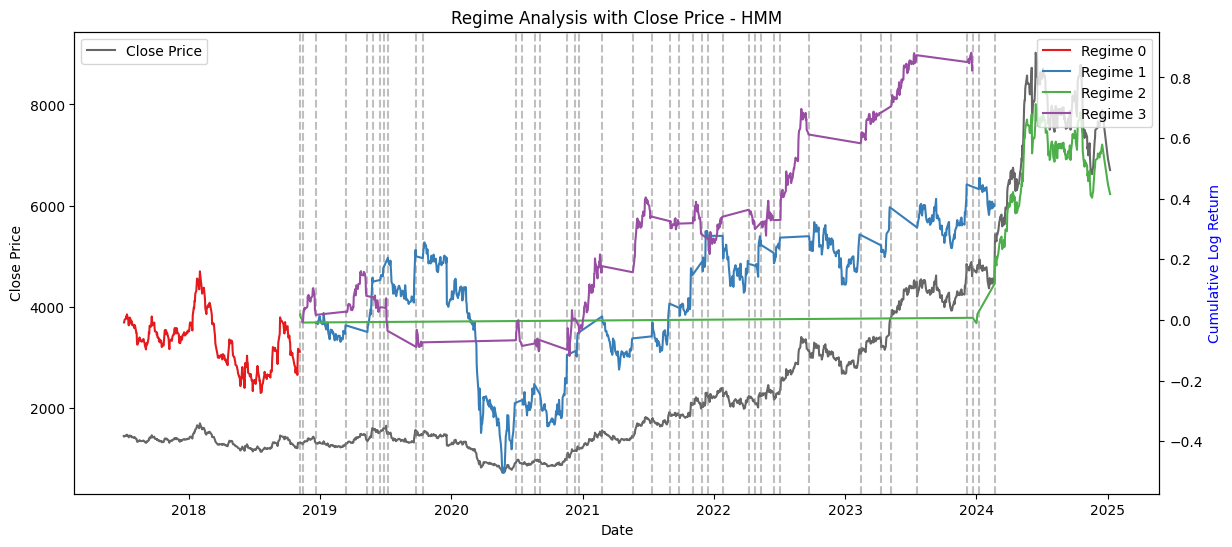

In [57]:
def plot_regime_analysis(df, regime_col, title):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("Set1", n_colors=df[regime_col].nunique())
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    ax1.plot(df.index, df['close'], color='black', label='Close Price', alpha=0.6)
    
    prev_regime = None
    for idx, row in df.iterrows():
        if prev_regime is not None and row[regime_col] != prev_regime:
            ax1.axvline(x=idx, color='gray', linestyle='dashed', alpha=0.5)
        prev_regime = row[regime_col]
    
    for regime, color in zip(sorted(df[regime_col].unique()), colors):
        regime_data = df[df[regime_col] == regime]
        ax2.plot(regime_data.index, regime_data['log_return'].cumsum(), label=f'Regime {regime}', color=color)
    
    ax1.set_ylabel('Close Price', color='black')
    ax2.set_ylabel('Cumulative Log Return', color='blue')
    ax1.set_xlabel('Date')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Regime Analysis with Close Price - {title}')
    plt.show()
# Plot GMM Regimes
plot_regime_analysis(featured_df, 'gmm_regime', 'GMM')

# Plot HMM Regimes
plot_regime_analysis(featured_df, 'hmm_regime', 'HMM')


In [54]:
featured_df


,open,high,low,close,lastprice,previouscloseprice,volume,totaltradingvolume,totaltradevalue,totalnumberoftradesexecuted,...,stoch_k,stoch_d,chande_momentum,ulcer_index,obv,chaikin_money_flow,seasonal_weekly,seasonal_yearly,gmm_regime,hmm_regime
date,,,,,,,,,,,,,,,,,,,,,
2017-07-04,1450.00,1470.00,1446.05,1449.90,1450.00,1448.65,1823,1823,2649665,262,...,0.000000,0.000000,0.000000,0.000000,-47502.0,0.000000,0.0,0.0,2,0
2017-07-05,1449.05,1473.50,1432.55,1438.20,1438.20,1449.90,7386,7386,10632853,665,...,0.000000,0.000000,0.000000,0.000000,-54888.0,0.000000,0.0,0.0,2,0
2017-07-06,1454.80,1460.80,1439.20,1445.75,1445.75,1438.20,105765,105765,153958432,414,...,0.000000,0.000000,0.000000,0.000000,50877.0,0.000000,0.0,0.0,2,0
2017-07-07,1457.70,1469.95,1443.80,1452.90,1452.90,1445.75,6195,6195,9001538,358,...,0.000000,0.000000,0.000000,0.000000,57072.0,-28270.199149,0.0,0.0,2,0
2017-07-10,1452.00,1480.00,1450.00,1455.40,1455.40,1452.90,8227,8227,12046734,440,...,0.000000,0.000000,0.000000,0.000000,65299.0,-28872.279231,0.0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-10,7585.00,7710.00,7572.25,7694.10,7684.50,7564.55,5208,5208,39940871,1771,...,92.911017,92.425667,18.316990,0.000000,-9664466.0,6180.854158,0.0,0.0,1,2
2024-12-12,7799.95,7799.95,7635.05,7654.95,7660.15,7725.80,3840,3840,29509077,1195,...,90.529267,91.351614,15.650372,10.463278,-9668306.0,4842.355629,0.0,0.0,1,2
2024-12-16,7726.30,7945.00,7709.00,7893.40,7888.00,7697.45,10909,10909,85970063,3429,...,93.894201,92.444829,26.513863,0.000000,-9657397.0,5807.772359,0.0,0.0,1,2


In [55]:
gmm_eval


{'Silhouette Score': 0.28451416,
 'Davies-Bouldin Index': 1.4237837850075217,
 'Kolmogorov-Smirnov': {'2-3': {'ks_stat': 0.09558642188440253,
   'p_value': 0.01541137509640614},
  '1-2': {'ks_stat': 0.1916286948016318, 'p_value': 4.273847633430945e-05},
  '1-3': {'ks_stat': 0.1059157111258426, 'p_value': 0.017250225951940052},
  '0-2': {'ks_stat': 0.1779565868263473, 'p_value': 0.2767356515631017},
  '0-1': {'ks_stat': 0.22385458167330677, 'p_value': 0.09813435348526622},
  '0-3': {'ks_stat': 0.1951194398682043, 'p_value': 0.16240332188217876}},
 'KL Divergence': {'2-3': 6.794638796457602,
  '1-2': 1.5941992751787126,
  '1-3': 0.30883678617635874,
  '0-2': 2.8135963526605026,
  '0-1': 1.2868941176506483,
  '0-3': 1.5974793424073421}}

In [56]:
hmm_eval


{'Silhouette Score': 0.15363486,
 'Davies-Bouldin Index': 1.7721735822118578,
 'Kolmogorov-Smirnov': {'0-2': {'ks_stat': 0.2036495496549304,
   'p_value': 4.202581201401613e-05},
  '0-3': {'ks_stat': 0.13229692965410028, 'p_value': 0.0020011967803188016},
  '0-1': {'ks_stat': 0.09551248472149468, 'p_value': 0.024436745273599295},
  '2-3': {'ks_stat': 0.1149911264223823, 'p_value': 0.04159946457681081},
  '1-2': {'ks_stat': 0.11355002110595187, 'p_value': 0.025870564396539113},
  '1-3': {'ks_stat': 0.07420134019012, 'p_value': 0.07071830747282026}},
 'KL Divergence': {'0-2': 8.701793033419978,
  '0-3': 0.9470429986920275,
  '0-1': 9.380728159119853,
  '2-3': 0.33182050214609327,
  '1-2': 0.5694634572368709,
  '1-3': 0.830660327375037}}